#Week 10: Batch Normalization

This week we discussed batch normalization where inputs to hidden layers in the model are normalized to provide a speed-up in training. Here we will be training a simple MNIST classifier and comparing a plain network to one with batch normalization to demonstrate the training speed-up and visualize some of the effects of BatchNorm on the neural network during training.

In [3]:
!pip install --upgrade torch -q
!pip install --upgrade torchvision -q

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [18]:
!pip install --upgrade seaborn -q

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [19]:
# Load the libraries and mnist data
import torch
from torch import nn
from torch import optim
import numpy as np
import seaborn as sns  # might need to install this one first
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from pathlib import Path

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    trainset, testset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

Let's see what some of our data looks like by plotting some of the MNIST images and the distribution of their pixels.

Image1 Size: (1, 28, 28)


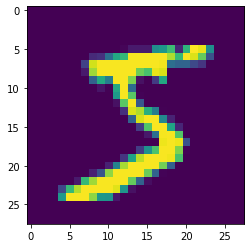

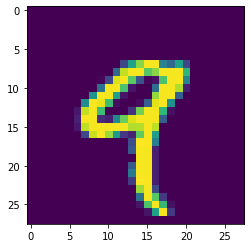

In [20]:
# plot some images
%matplotlib inline
img1 = dataset[0][0]
print("Image1 Size:", tuple(img1.shape))
new_img1 = img1.reshape(28,28)

img2 = dataset[4][0]
new_img2 = img2.reshape(28,28)

plt.figure()
plt.imshow(new_img1)
plt.figure()
plt.imshow(new_img2)

Text(0.5, 1.0, 'distribution of pixels (img2)')

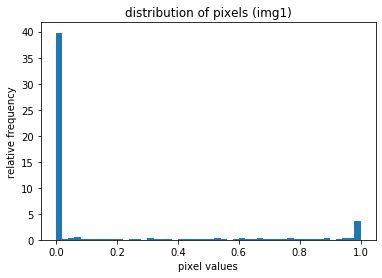

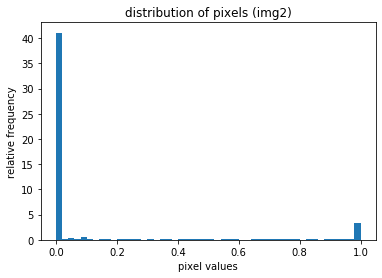

In [21]:
# convert image to numpy array
img_np1 = np.array(new_img1) 
# plot the pixel values
plt.figure()
plt.hist(img_np1.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img1)")

# convert image to numpy array
img_np2 = np.array(new_img2) 
# plot the pixel values
plt.figure()
plt.hist(img_np2.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img2)")

In [22]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [23]:
# Create a test and training set
batch_size = 60

to_device = lambda a: a.to(device)

testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [24]:
# Used later to view hidden layer activations
class ActivationTracker(nn.Module):
    '''keeps track of the current activation'''
    def __init__(self):
        super(ActivationTracker, self).__init__()

        # Keep track of [0.15, 0.5, 0.85] percentiles
        self.percents_activation_track = torch.tensor([0.15, 0.50, 0.85]).to(device)
        self.all_percents_activation = []

    def get_all_activations(self):
        return np.array(self.all_percents_activation)
        
    def forward(self, x):
        # track activations of the first node
        percents_activation = torch.quantile(x.detach()[:,0], self.percents_activation_track)
        self.all_percents_activation.append(percents_activation.cpu().detach().numpy())
        return x

In [25]:
#initialize linear layer weights with a gaussian as done in the paper
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight,0, 0.1)
        m.bias.data.fill_(0.01)

In [78]:
# Create a basic network
class VanillaNN(nn.Module):
    def __init__(self): 
        super(VanillaNN, self).__init__()
        self.classifier = nn.Sequential(
            # TODO: what should the input dim be? Hint: size of img data
            nn.Linear(28*28, 48),  # layer 1
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            ActivationTracker(),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
      return self.classifier

In [80]:
# Using the same structure of the basic network as above, add batch normalization to the input layers
class BatchNormNN(nn.Module):
    def __init__(self): 
        super(BatchNormNN, self).__init__()
        self.classifier = nn.Sequential(
            #TODO: what should the input dim be? Hint: size of img data
            nn.Linear(28*28, 48),   # layer 1
            # TODO: Add batch norm layers before each activation -> nn.BatchNorm1d(size)
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            
            ActivationTracker(),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
      return self.classifier

In [81]:
# Used to get the accuracy of a given model
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

Now that we have our data and models defined, let's train both models using the same parameters and compare their loss over time.

In [82]:
# Start here to train the models
model = VanillaNN().to(device)
print(model)
model_bn = BatchNormNN().to(device)
print(model_bn)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

VanillaNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ActivationTracker()
    (4): ReLU()
    (5): Linear(in_features=24, out_features=10, bias=True)
  )
)
BatchNormNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): ActivationTracker()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=24, out_features=10, bias=True)
  )
)


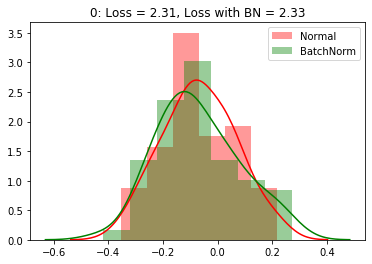

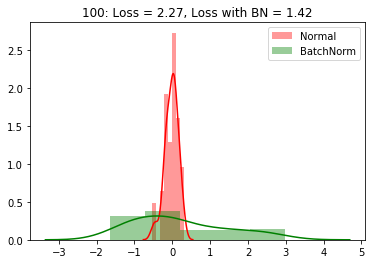

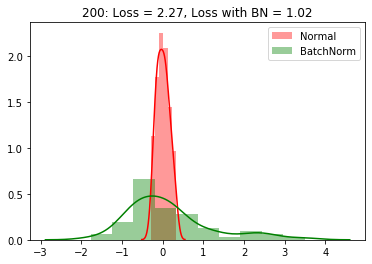

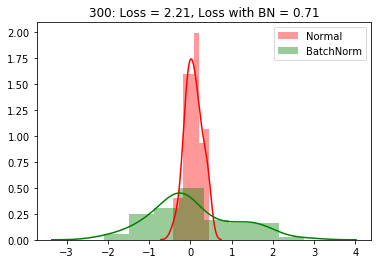

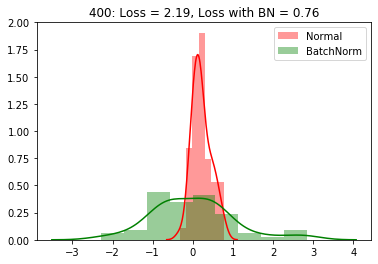

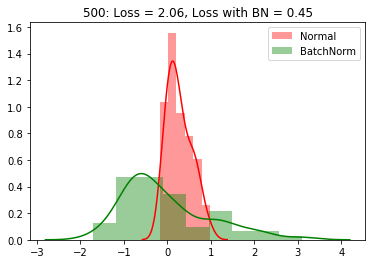

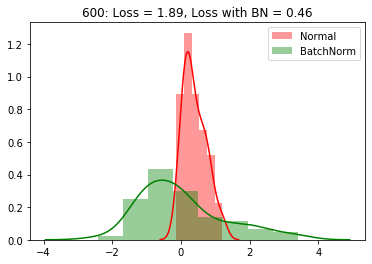

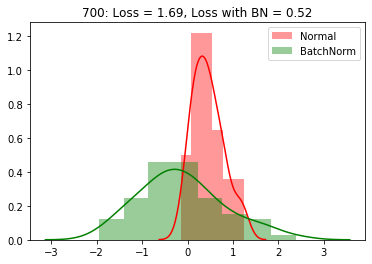

----------------------
0


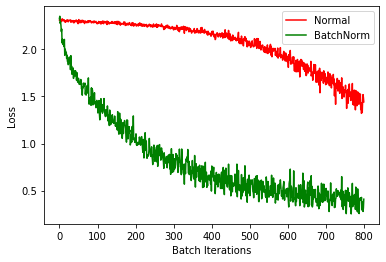

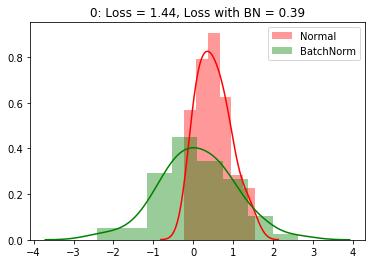

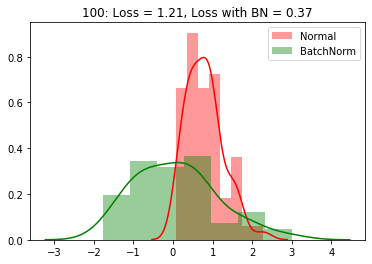

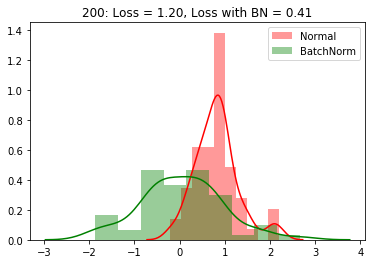

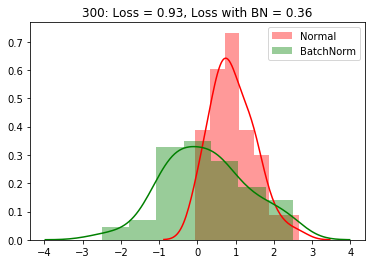

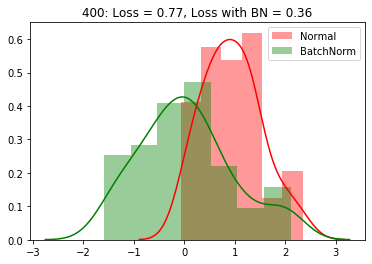

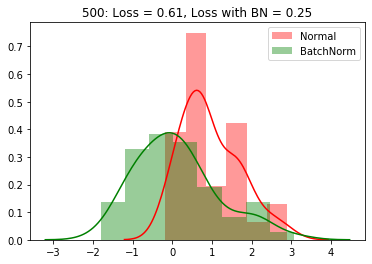

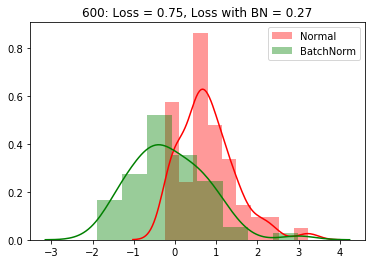

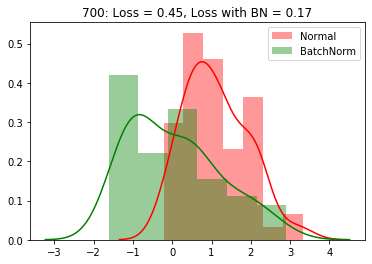

----------------------
1


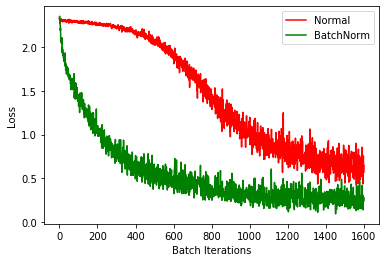

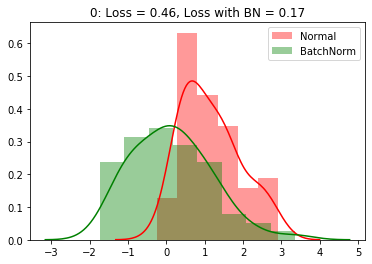

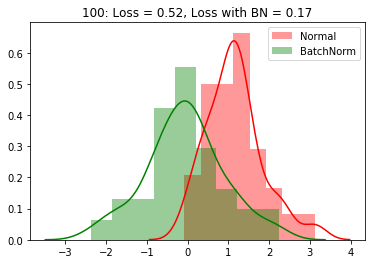

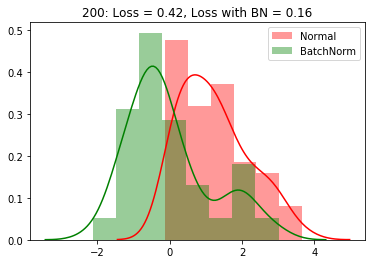

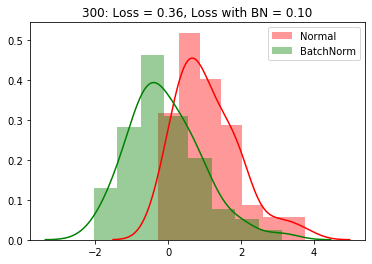

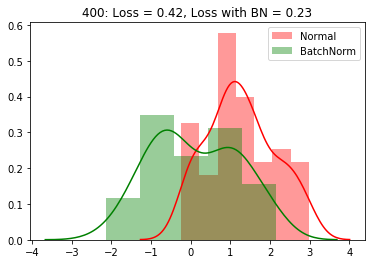

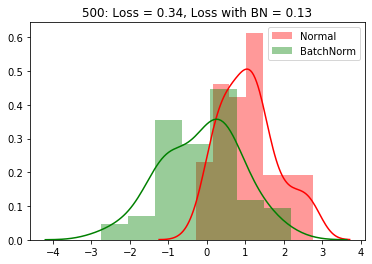

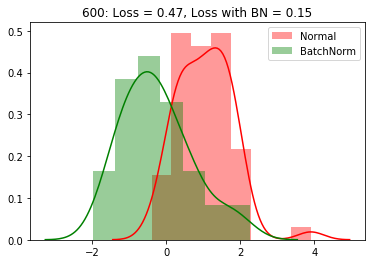

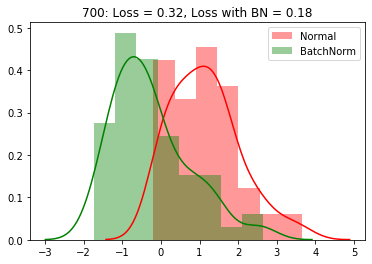

----------------------
2


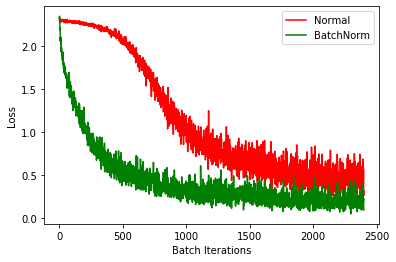

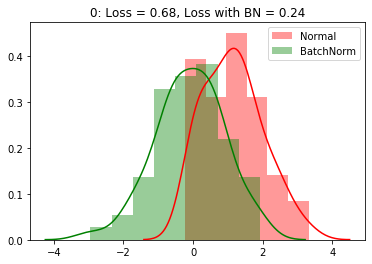

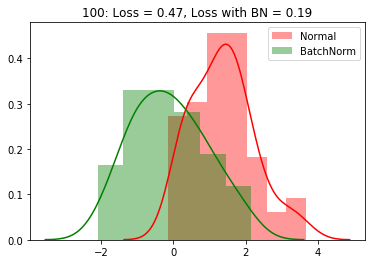

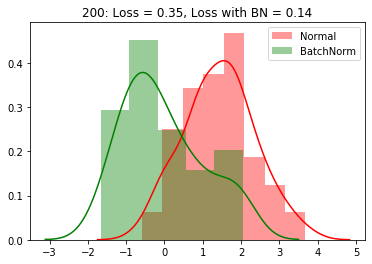

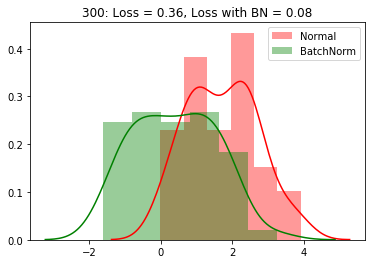

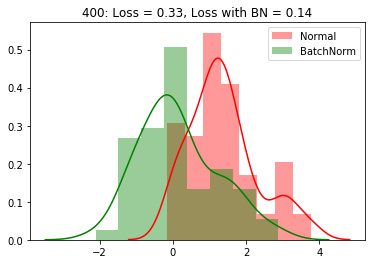

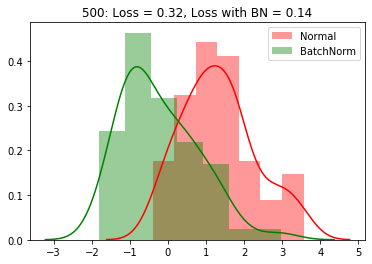

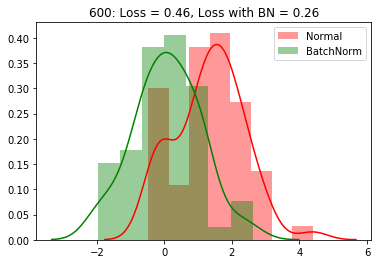

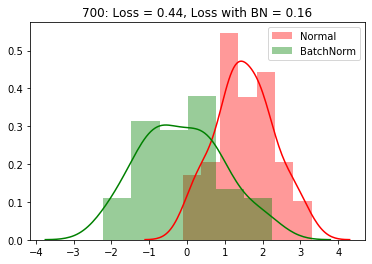

----------------------
3


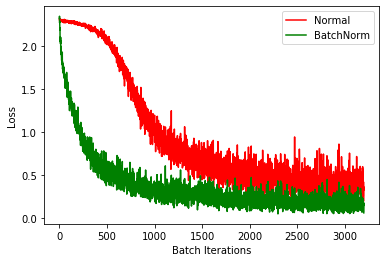

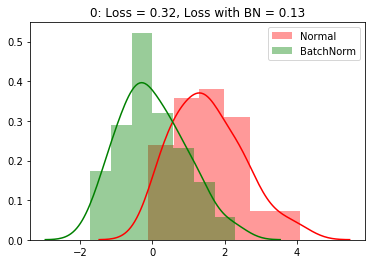

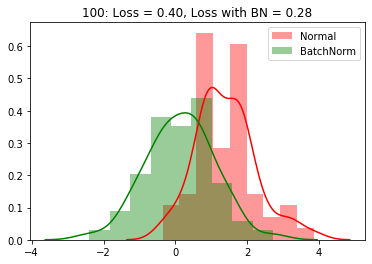

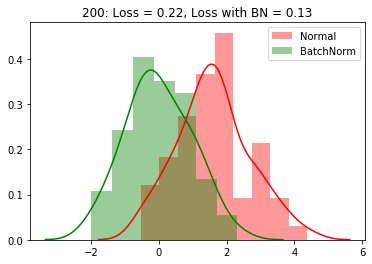

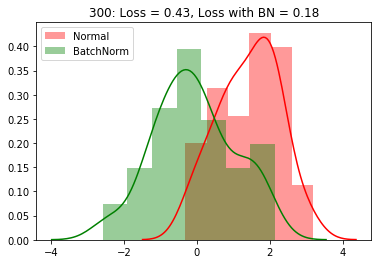

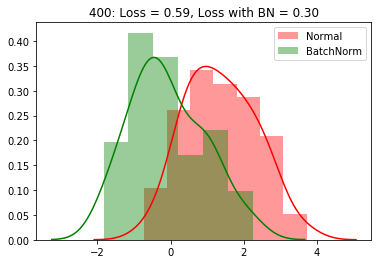

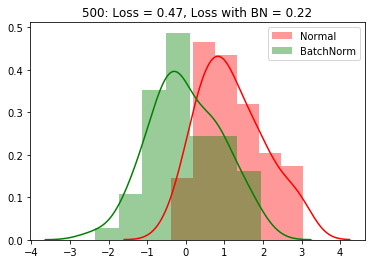

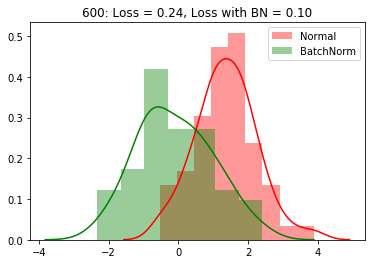

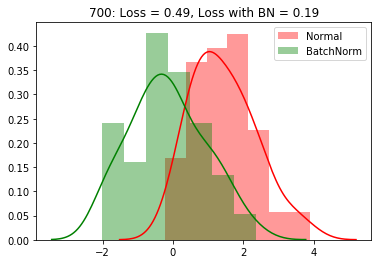

----------------------
4


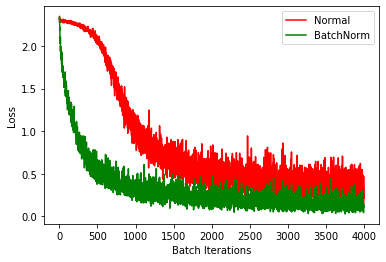

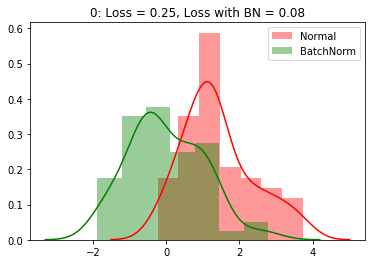

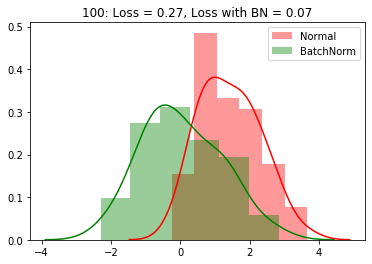

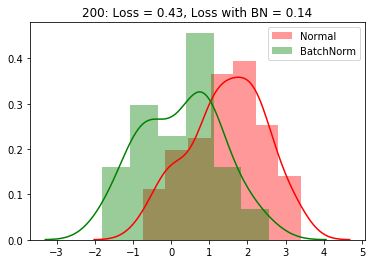

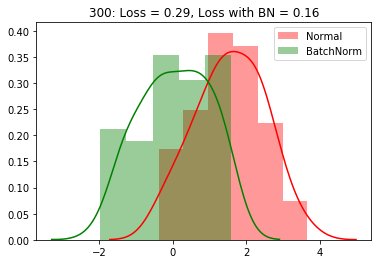

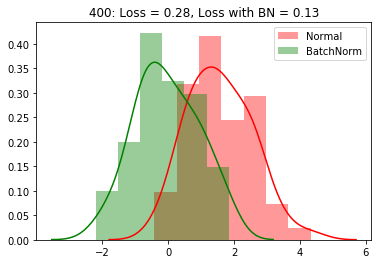

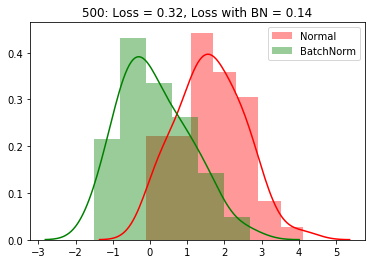

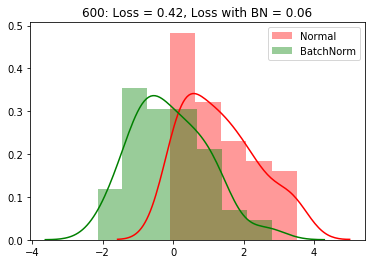

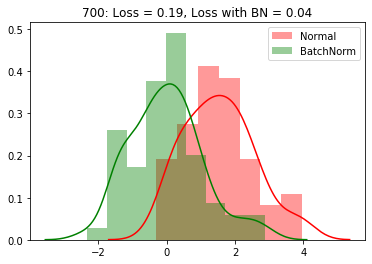

----------------------
5


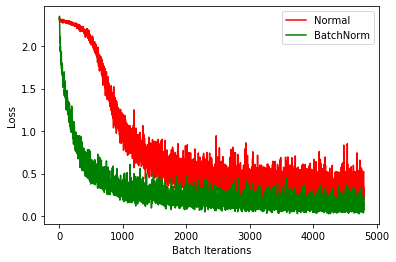

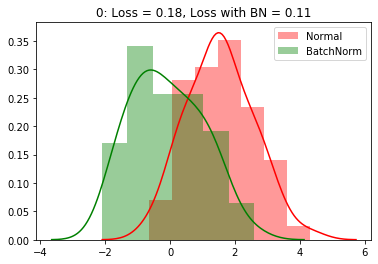

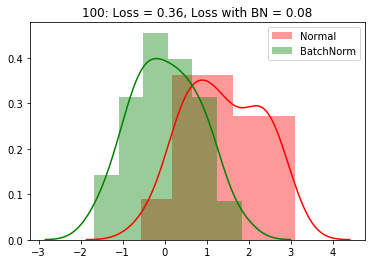

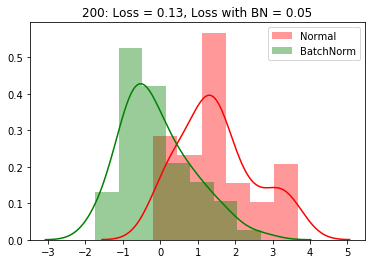

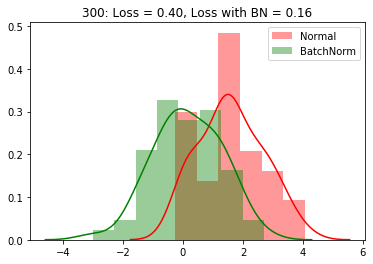

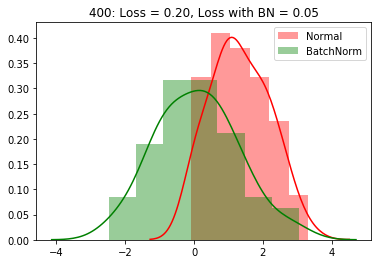

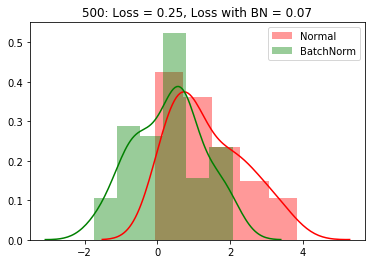

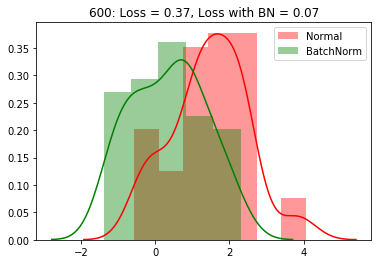

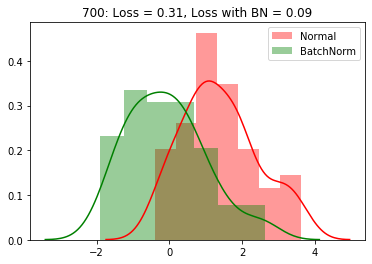

----------------------
6


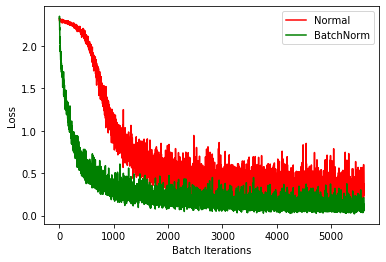

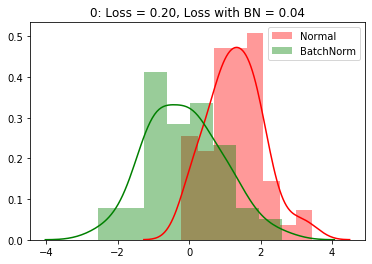

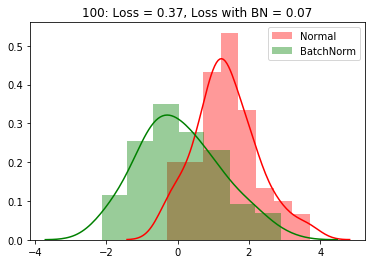

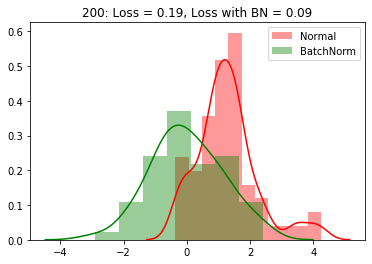

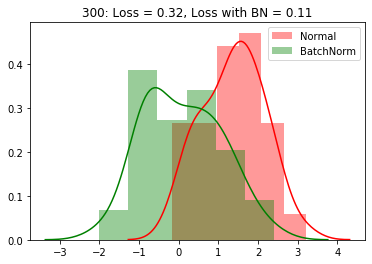

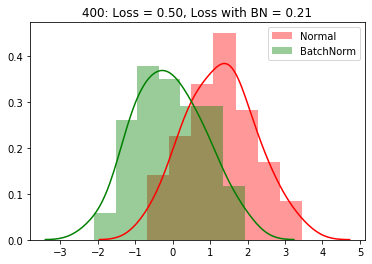

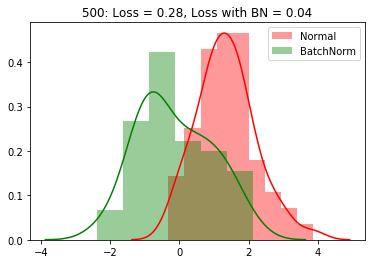

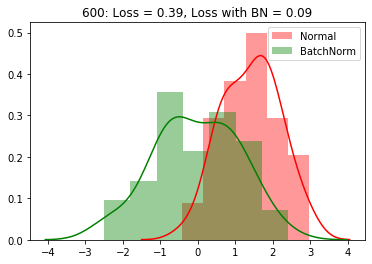

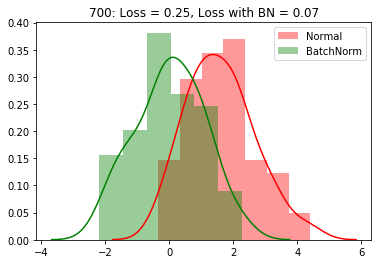

----------------------
7


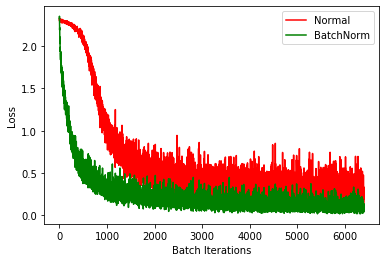

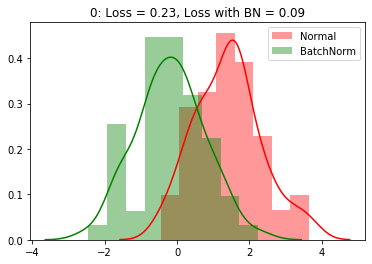

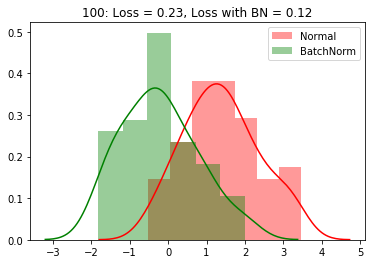

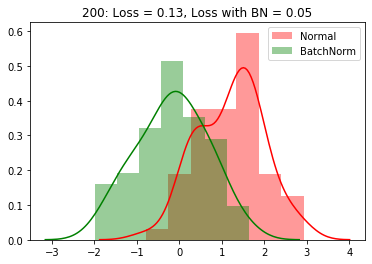

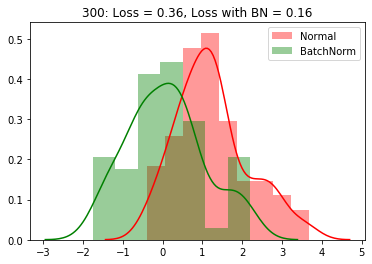

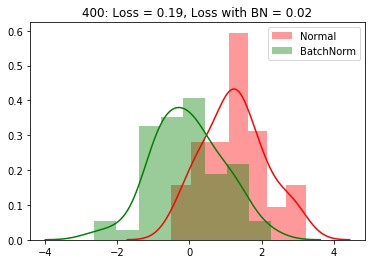

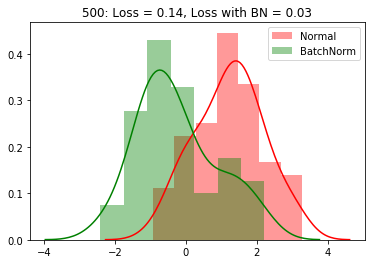

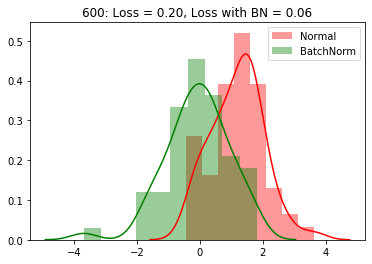

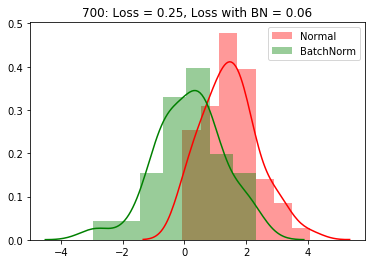

----------------------
8


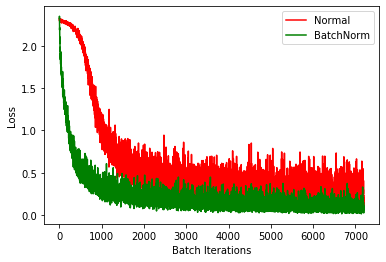

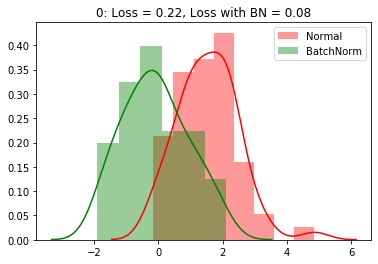

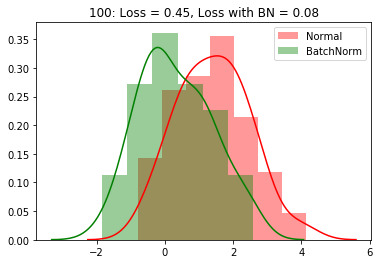

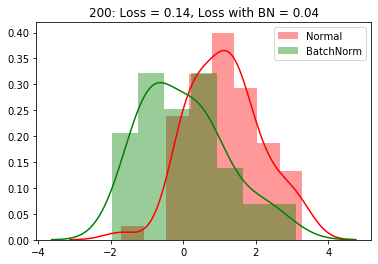

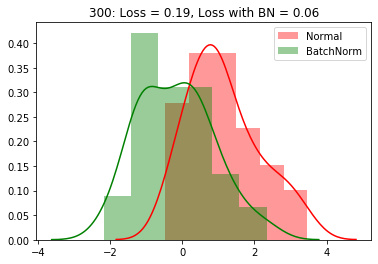

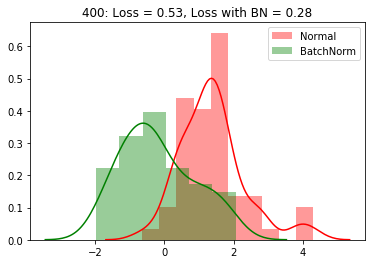

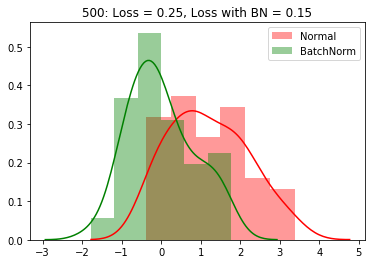

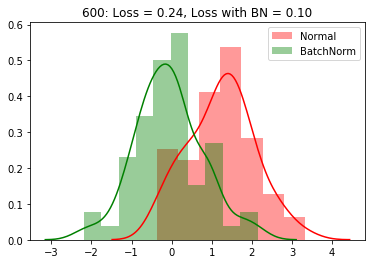

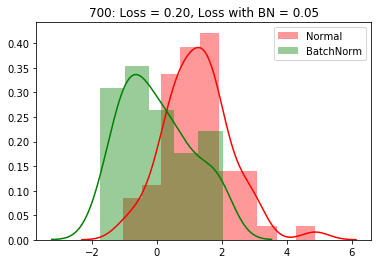

----------------------
9


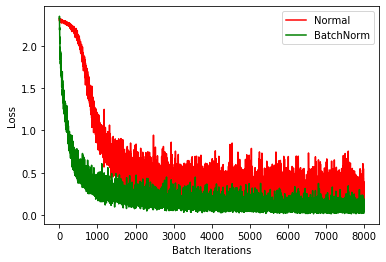

In [83]:
loss_arr = []
loss_bn_arr = []
epochs_stats = []

# TODO: set number of epochs
max_epochs = 10

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        
        

        # training steps for normal model
        # print("train")
        # activations get added here so track iteration
        epochs_stats.append(i+epoch*len(trainloader))
        opt.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs.to(device))
        loss_bn = loss_fn(outputs_bn, labels.to(device))
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        
        if i % 100 == 0:
            inputs = inputs.view(inputs.size(0), -1)
            model.eval()
            model_bn.eval()
            
            # plot input layer distributions
            # first linear layer
            a = model.classifier[0](inputs.to(device))
            # inputs to first layer, first node
            a = a[:,0].cpu().detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            # first linear layer, batch layer
            b = model_bn.classifier[0](inputs.to(device))
            b = model_bn.classifier[1](b)
            # inputs to first layer, first node
            b = b[:,0].cpu().detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with BN = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            model.train()
            model_bn.train()
        
    print('----------------------')
    print(epoch)
    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.xlabel("Batch Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# loss of the network with batch normalization reduces much faster than the normal network

There were quite a few visualizations produced while training the models.
We have density plots which show the distribution of the inputs to the first activation for the first node for each model and the loss of the models throughout batch iterations. 

**TODO: what are we seeing from the density plots? Think about the pixel value distributions of some of the MNIST data at the beginning, would this influence the output of our plots?**

The differences in distributions are pronounced early in training, with a greater spread of pixel value over the Vanilla network, where values are concentrated at the center.


**TODO: compare the loss over time from the vanilla model with the batch norm model. What can we infer from this?**

BatchNorm converges much quicker, which I think means we can infer the gradient is more easily descended on normalized datapoints

In [90]:
# Get last hidden layer activation (ActivationTracker layer)
# TODO: which layer of the model to use?
baseline_activation = model.get_model()[3].get_all_activations()
bn_activation = model_bn.get_model()[4].get_all_activations()
print(len(baseline_activation))  # will match len(epochs_stats)
print(len(epochs_stats))

8000
8000


In the paper, they show how the activations from the last layer change during training and compare the Vanilla network to the BatchNorm network (Figure 1(b) and 1(c)).

**TODO: What effect would we expect BatchNorm to have on these last layer activations?**

We should expect a the activations to start with significant space between the traces, as opposed to vanilla where they seem to start from the same point

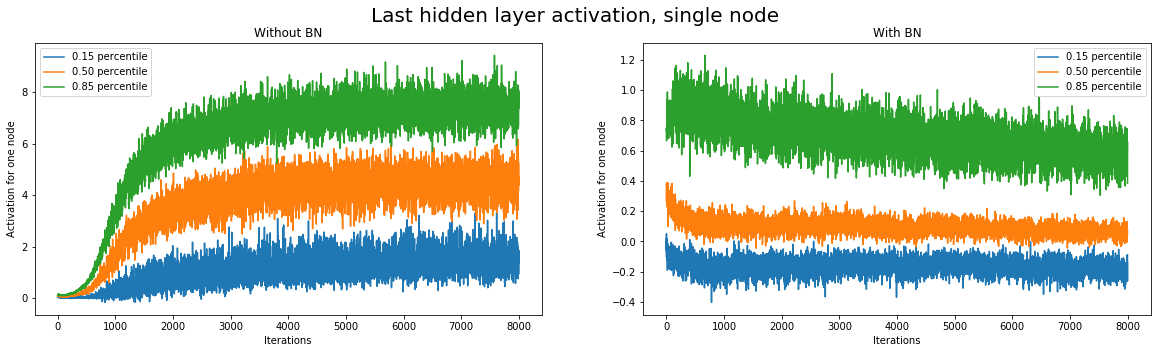

In [91]:
# Display activations
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # -- All iterations
    # Baseline
    ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation for one node')
    
    # BN based
    ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation for one node')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('Last hidden layer activation, single node', fontsize=20)
    plt.show()

**TODO: How do your plots compare to those in the paper? How do they compare to each other? What might explain the differences that you're seeing?**


Charts appear to be similar to those in the paper. The main difference I see in comparing the charts to each other is early in training, the VN network sees a "bump" in activation across the three cuts, where the Vanilla network doesn't show this signature. It is uncleaer how real this signature is.

**TODO: If you make changes to the architecture or training regime, how does this affect the behavior of these last activation values?**

So in experimenting with a network having more hidden layers, the difference in convergence appears more pronounced. BN loss appears significantly smoother,

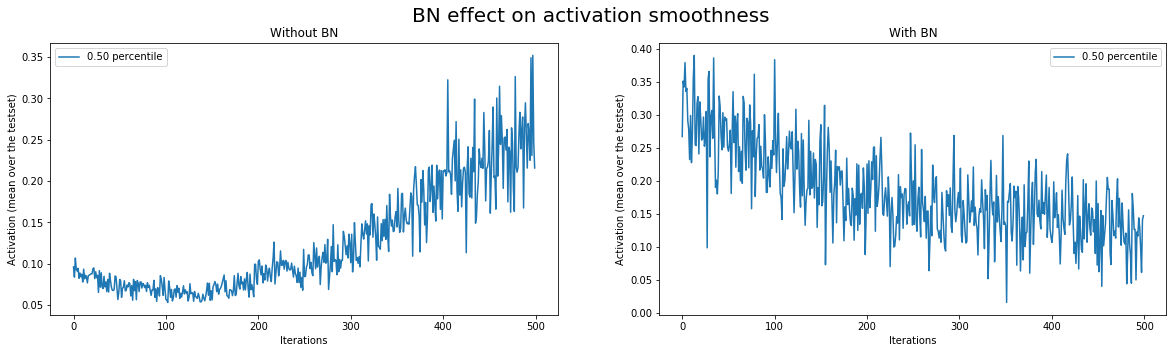

In [92]:
# --Zoom into beginning of above plots to visualize smoothing effect
small_window = 500

if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # Baseline
    ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('BN effect on activation smoothness', fontsize=20)
    plt.show()

In [93]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model, trainloader)
print(f"Epoch {epoch} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model, testloader)

print(f"Epoch {epoch} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn, trainloader)
print(f"Epoch {epoch} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn, testloader)
print(f"Epoch {epoch} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 9 Vanilla Train Accuracy: 92.36%
Epoch 9 Vanilla Test Accuracy: 92.14%

Epoch 9 BN Train Accuracy: 97.82%
Epoch 9 BN Test Accuracy: 96.39%



**TODO: How does the accuracy of the models with and without BatchNorm compare? How does this change when you change the architecture, learning rate, or number of iterations?**


We see a 5% increase in train/test accuracy in the BN model over Vanilla. This is cool that training is faster but also improves accuracy. 